In [1]:
!python --version

In [1]:
import os
os.chdir("..")
from rice import Rice
import torch
import numpy as np

from tqdm import tqdm

import copy

import helper_scripts
from PPO_copied import PPO

In [2]:
env = Rice(region_yamls_filename='fewer_region_yamls/')

In [3]:
def create_agents(env : Rice):
    agents = []
    initial_state = env.reset()
    for i in range(env.num_regions):
        agents.append(
            PPO(
                state_dim = len(initial_state[i]['features']), 
                action_dim = env.action_space[i]
            )
        )
    return agents

In [4]:
agents = helper_scripts.create_agents(env)

In [5]:
epochs = 20
batch_size = 16

In [6]:
rewards = {i : [] for i in range(len(agents))}

for epoch in tqdm(range(epochs)):
    for batch in range(batch_size):
        state = env.reset()
        for t in range(env.episode_length):
            collective_action = {}
            for agent_id in range(len(agents)):
                collective_action[agent_id] = agents[agent_id].select_action(state[agent_id])
            state, reward, _, _ = env.step(collective_action)
            for agent_id in range(len(agents)):
                agents[agent_id].buffer.rewards.append(reward[agent_id])
                agents[agent_id].buffer.is_terminals.append(t == env.episode_length - 1)
                
                rewards[agent_id].append(reward[agent_id])
            
    for agent in agents:
        agent.update()

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████| 20/20 [01:21<00:00,  4.06s/it]


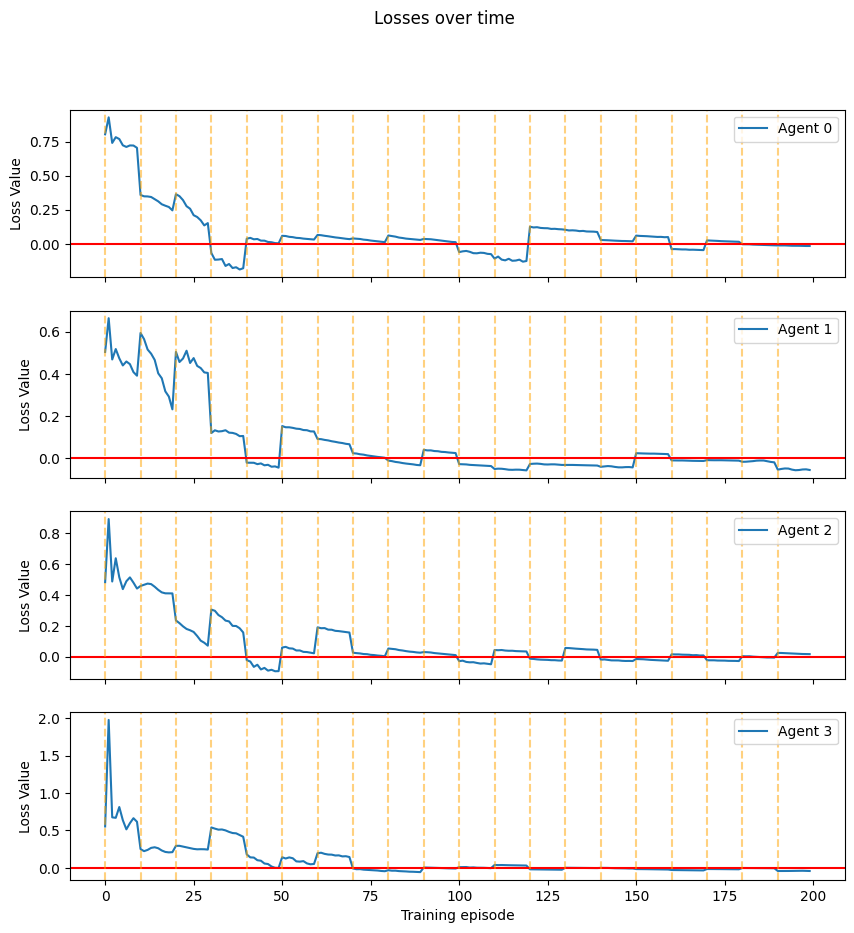

In [7]:
helper_scripts.plot_losses(agents, agents[0].K_epochs)

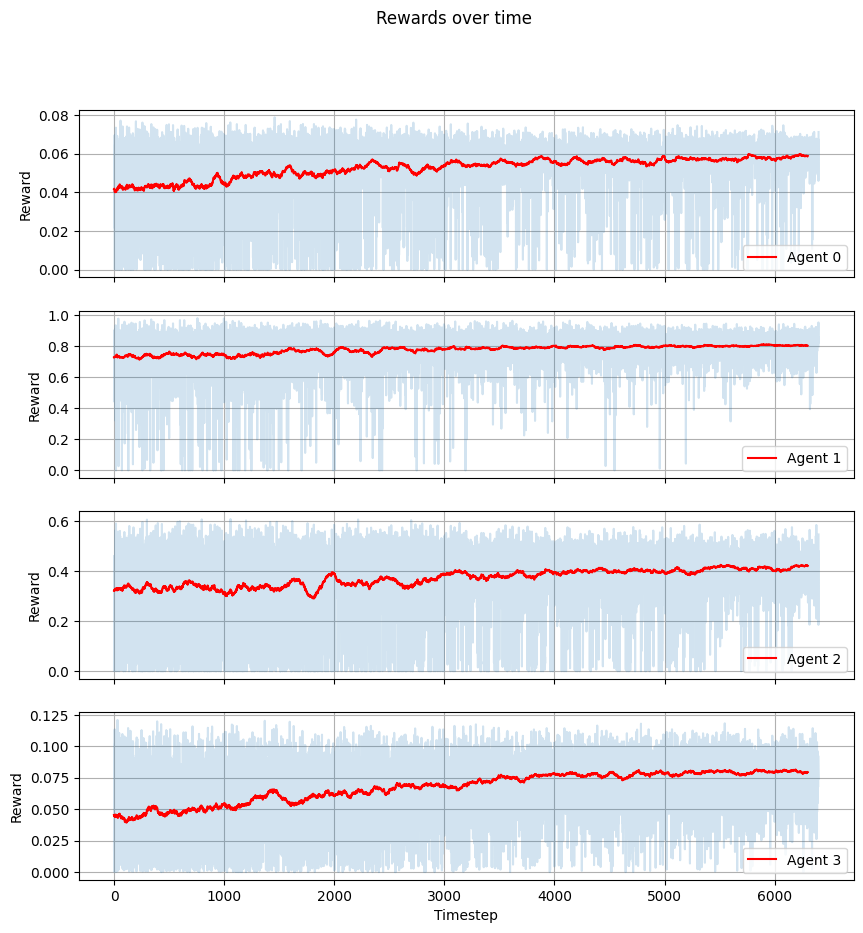

In [8]:
helper_scripts.plot_rewards(rewards)

In [9]:
t, a_t, _ = helper_scripts.evaluate_agents(agents, env)
b, a_b, _ = helper_scripts.baseline(env)

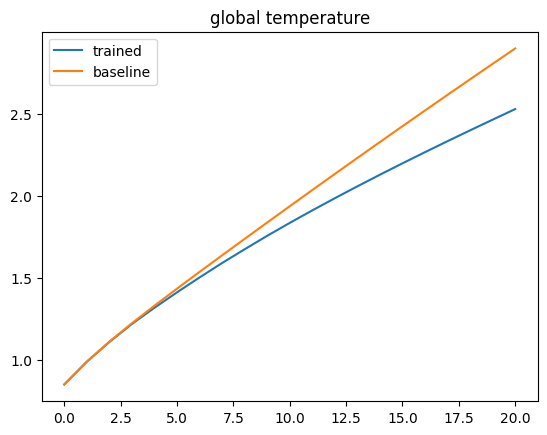

In [10]:
import matplotlib.pyplot as plt
plt.plot(t['global_temperature']['value'][:, 0], label = 'trained')
plt.plot(b['global_temperature']['value'][:, 0], label = 'baseline')
plt.legend()
plt.title('global temperature')
plt.show()